In [15]:
import torch
import torch.nn as nn
import numpy as np
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import torchvision

In [16]:
# Only not modularizing the generator and discriminator blocks b/c of NotImplemented errors on MPS backend

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        
        m.weight.data.normal_(0.0, 0.02)
        # print("CONV INITIALIZED")
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        # print("BN INITIALIZED")

class Generator(nn.Module):
    def __init__(self, latent_dim, n_features, n_channels, batch_size, device):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_features = n_features
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.device = device

        # self.net = nn.Sequential(
        #     nn.ConvTranspose2d(self.latent_dim, self.n_features*8,4,2,1,bias=False),
        #     nn.BatchNorm2d(self.n_features*8),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(self.n_features*8, self.n_features*4,4,2,1,bias=False),
        #     nn.BatchNorm2d(self.n_features*4),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(self.n_features*4, self.n_features*2,4,2,1,bias=False),
        #     nn.BatchNorm2d(self.n_features*2),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(self.n_features*2, self.n_features*1,4,2,1,bias=False),
        #     nn.BatchNorm2d(self.n_features*1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(self.n_features*1, self.n_channels,4,2,1,bias=False),
        #     nn.Tanh()
        # )
        def _block(in_channels, out_channels, kernel_size, stride, padding):
            conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
            # torch.nn.init.normal_(conv.weight, 0, 0.02)
            bn = nn.BatchNorm2d(out_channels)
            # torch.nn.init.normal_(bn.weight, 1, 0.2)
            return nn.Sequential(
                conv,
                bn,
                nn.ReLU()
            )

        self.net = nn.Sequential(
            _block(self.latent_dim, self.n_features*8, 4, 2, 1),
            _block(self.n_features*8, self.n_features*4, 4, 2, 1),
            _block(self.n_features*4, self.n_features*2, 4, 2, 1),
            _block(self.n_features*2, self.n_features, 4, 2, 1),
            nn.ConvTranspose2d(self.n_features, self.n_channels, 4,2,1),
            nn.Tanh()
        )

 



    def forward(self):
        X = torch.randn(self.batch_size, self.latent_dim).unsqueeze(-1).unsqueeze(-1)
        X = X.to(self.device)
        return self.net(X)

class Discriminator(nn.Module):
    def __init__(self, n_features, n_channels):
        super(Discriminator, self).__init__()
        self.n_features = n_features
        self.n_channels = n_channels
# c1 = nn.Conv2d(3, 16, 4,2,1)
# c2 = nn.Conv2d(16, 32, 4,2,1)
# c3 = nn.Conv2d(32, 64, 4,2,1)
# c4 = nn.Conv2d(64, 128, 4,2,1)
# c5 = nn.Conv2d(128, 1, 2,2,0)
        self.net = nn.Sequential(
            nn.Conv2d(self.n_channels, self.n_features, 4,2,1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.n_features, self.n_features*2,4,2,1,bias=False),
            nn.BatchNorm2d(self.n_features*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.n_features*2, self.n_features*4, 4,2,1,bias=False),
            nn.BatchNorm2d(self.n_features*4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.n_features*4, self.n_features*8, 4,2,1,bias=False),
            nn.BatchNorm2d(self.n_features*8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.n_features*8, 1, 2,2,0,bias=False),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.net(X).view(-1,1).squeeze(1)


In [17]:
device = torch.device("mps")
bs = 128

disc = Discriminator(64, 3)
disc.apply(weights_init)
disc = disc.to(device)
gen = Generator(100,64,3,bs, device)
gen.apply(weights_init)
gen = gen.to(device)

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Resize((64,64)),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])


dataset = torchvision.datasets.CIFAR10("./data", train=True, transform=transforms, download=True)


loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
num_epochs = 10
loss_fn = nn.BCELoss()

optim_disc = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))
optim_gen = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_losses = []
gen_losses = []


Files already downloaded and verified


In [18]:
for ep in range(num_epochs):
    print(f"Starting epoch {ep}")
    for src, _ in tqdm(loader):    
        optim_disc.zero_grad()
        optim_gen.zero_grad()
        src = src.to(device)

        real = src
        fake = gen()
        # print("FAKE: ", fake.shape)
        # print("Real: ",real.shape)

        disc_real = disc(real)
        disc_fake = disc(fake)

        # print(f"Real {disc_real.shape} Fake {disc_fake.shape}")

        disc_real_loss = loss_fn(disc_real, torch.ones_like(disc_real))
        disc_fake_loss = loss_fn(disc_fake, torch.zeros_like(disc_fake))

        disc_loss = (disc_real_loss + disc_fake_loss) / 2
        disc_losses.append(disc_loss.item())
        disc_loss.backward(retain_graph=True)
        optim_disc.step()

        out = disc(fake)
        gen_loss = loss_fn(out, torch.ones_like(out))
        gen_losses.append(gen_loss.item())
        gen_loss.backward()
        optim_gen.step()


Starting epoch 0


100%|██████████| 391/391 [01:01<00:00,  6.35it/s]


Starting epoch 1


100%|██████████| 391/391 [01:02<00:00,  6.29it/s]


Starting epoch 2


100%|██████████| 391/391 [01:01<00:00,  6.37it/s]


Starting epoch 3


100%|██████████| 391/391 [01:01<00:00,  6.31it/s]


Starting epoch 4


100%|██████████| 391/391 [01:03<00:00,  6.20it/s]


Starting epoch 5


100%|██████████| 391/391 [01:00<00:00,  6.44it/s]


Starting epoch 6


100%|██████████| 391/391 [01:00<00:00,  6.44it/s]


Starting epoch 7


100%|██████████| 391/391 [01:00<00:00,  6.42it/s]


Starting epoch 8


100%|██████████| 391/391 [01:03<00:00,  6.11it/s]


Starting epoch 9


100%|██████████| 391/391 [01:02<00:00,  6.25it/s]


In [20]:
# Save progress

torch.save({
    "epoch": ep,
    "disc_state": disc.state_dict(),
    "gen_state": gen.state_dict(),
    "optim_disc": optim_disc.state_dict(),
    "optim_gen": optim_gen.state_dict(),
    "gen_losses" : gen_losses,
    "disc_losses": disc_losses,
    "disc_loss": disc_loss.item(),
    "gen_loss": gen_loss.item()
}, f"./weights/dcgan_cifar_{ep}.pt")

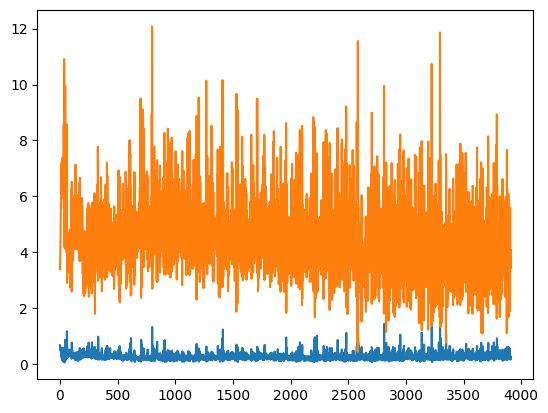

In [21]:
plt.plot(disc_losses)
plt.plot(gen_losses)

In [22]:
from torchvision.utils import make_grid

def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)


    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        print("Ns")
    else:
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])
tensor(-1., device='mps:0') tensor(1.0000, device='mps:0')


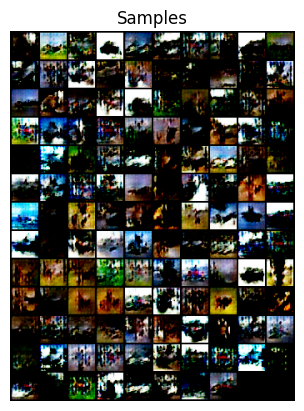

In [25]:
with torch.no_grad():
    gen.eval()
    samps = gen()
    print(samps.shape)
    print(torch.min(samps), torch.max(samps))
    show_samples(samps.cpu().permute(0,2,3,1))
